In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score

In [80]:
# load the dataset
ratings_df = pd.read_csv('../datasets/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df.drop(columns='timestamp', inplace=True)

# Conta il numero di rating per ogni utente
user_rating_counts = ratings_df['user_id'].value_counts()

# Tieni solo gli utenti con almeno 20 valutazioni
active_users = user_rating_counts[user_rating_counts >= 20].index

# Filtra il dataset originale
filtered_df = ratings_df[ratings_df['user_id'].isin(active_users)]
print(f"Numero di utenti attivi (almeno 20 valutazioni): {len(active_users)} (total: {len(ratings_df['user_id'].unique())})")
ratings_df.head()

Numero di utenti attivi (almeno 20 valutazioni): 943 (total: 943)


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [81]:
# Split
ratings_train, ratings_test = train_test_split(ratings_df, test_size=0.3, random_state=42)
ratings_train = pd.DataFrame(ratings_train, columns=['user_id', 'movie_id', 'rating'])
ratings_test = pd.DataFrame(ratings_test, columns=['user_id', 'movie_id', 'rating'])
# Set di utenti e film
train_users = set(ratings_train['user_id'])
train_movies = set(ratings_train['movie_id'])
test_users = set(ratings_test['user_id'])
test_movies = set(ratings_test['movie_id'])

# Cold start
cold_start_users = test_users - train_users
cold_start_movies = test_movies - train_movies

# Rimuove film e utenti non visti
ratings_test = ratings_test[
    (~ratings_test['movie_id'].isin(cold_start_movies)) &
    (~ratings_test['user_id'].isin(cold_start_users))
]

# Report
print(f"Numero di utenti nel test set non visti nel training set: {len(cold_start_users)}")
print(f"Numero di film nel test set non visti nel training set: {len(cold_start_movies)}")
print(f"Percentuale di cold start utenti: {len(cold_start_users)/len(test_users)*100:.2f}%")
print(f"Percentuale di cold start film: {len(cold_start_movies)/len(test_movies)*100:.2f}%")
print(f"Train set: {len(ratings_train)} ratings")
print(f"Test set filtrato: {len(ratings_test)} ratings")

Numero di utenti nel test set non visti nel training set: 0
Numero di film nel test set non visti nel training set: 51
Percentuale di cold start utenti: 0.00%
Percentuale di cold start film: 3.40%
Train set: 70000 ratings
Test set filtrato: 29940 ratings


In [82]:
rating_matrix = ratings_train.pivot(index='user_id', columns='movie_id', values='rating')
rating_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1667,1668,1670,1671,1672,1673,1676,1678,1679,1680
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,NaN,NaN,3.0,NaN,4.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
def create_similarity_matrix(rating_matrix, similarity: str):
    """
    Crea una matrice di similarità tra gli utenti basata sulla metrica specificata.
    """
    R_centered = rating_matrix.sub(rating_matrix.mean(axis=1), axis=0)
    R_filled_user = R_centered.fillna(0)
    if similarity == "pearson":   
        similarity_matrix = 1 - pairwise_distances(R_filled_user, metric="correlation")
    elif similarity == "cosine":
        similarity_matrix = cosine_similarity(R_filled_user)
    else:
        raise ValueError("Unsupported similarity metric. Use 'pearson' or 'cosine'.")

    return pd.DataFrame(similarity_matrix, index=rating_matrix.index, columns=rating_matrix.index)

In [84]:
def predict_ratings_user_based(rating_matrix, similarity):
    """
    Calcola la matrice di predizione dei voti usando il Collaborative Filtering user-based.

    Parametri:
    - rating_matrix (DataFrame): matrice utenti-elementi con voti.
    - similarity (str): metrica di similarità usata.

    Ritorna:
    - prediction_matrix (DataFrame): matrice dei voti predetti.
    """
    similarity_matrix = create_similarity_matrix(rating_matrix, similarity)

    # 1. Calcola la media dei voti per ogni utente (ignorando gli zeri)
    user_means = rating_matrix.replace(0, np.nan).mean(axis=1)

    # 2. Calcola lo scarto di ogni voto rispetto alla media dell'utente
    user_centered = rating_matrix.sub(user_means, axis=0).fillna(0)

    # 3. Calcola il numeratore: prodotto scalare tra similarità e scarti
    numerator_user = similarity_matrix.dot(user_centered)

    # 4. Calcola il denominatore: somma dei valori assoluti delle similarità
    denominator_user = np.abs(similarity_matrix).sum(axis=1)

    # 5. Calcola la predizione aggiungendo la media utente e arrotondando
    prediction_matrix = numerator_user.div(denominator_user, axis=0).add(user_means, axis=0)

    # Applica soglia e arrotondamento
    prediction_matrix = prediction_matrix.map(lambda x: 0 if x < 0.5 else 5 if x >= 5.5 else math.floor(x + 0.5))

    return prediction_matrix


In [85]:
prediction_df_cosine = predict_ratings_user_based(rating_matrix, "cosine")
prediction_df_pearson = predict_ratings_user_based(rating_matrix, "pearson")

# Visualizza le prime 5 righe della matrice di predizione
print("Predizioni con Similarità Coseno:") 
print(prediction_df_cosine.head())

print("Predizioni con Similarità Pearson:")
print(prediction_df_pearson.head())

Predizioni con Similarità Coseno:
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1            4     4     4     4     4     4     4     4     4     4  ...   
2            4     4     4     4     4     4     4     4     4     4  ...   
3            3     3     3     3     3     3     3     3     3     3  ...   
4            4     5     4     4     5     4     4     5     4     5  ...   
5            3     3     3     3     3     3     3     3     3     3  ...   

movie_id  1667  1668  1670  1671  1672  1673  1676  1678  1679  1680  
user_id                                                               
1            4     4     4     4     4     4     4     4     4     4  
2            4     4     4     4     4     4     4     4     4     4  
3            3     3     3     3     3     3     3     3     3     3  
4            4     4     4     4     4     5     4     5     5     5  


In [86]:
prediction_df_cosine = prediction_df_cosine.reset_index().melt(id_vars='user_id', var_name='movie_id', value_name='predicted_rating')
prediction_df_pearson = prediction_df_pearson.reset_index().melt(id_vars='user_id', var_name='movie_id', value_name='predicted_rating')

In [87]:
def evaluate_ratings(ratings_test, prediction_df, thresholds=[3.0]):
    # Unione dei dataframe test e predizioni
    valutazione_df = ratings_test.merge(prediction_df, on=["user_id", "movie_id"], how="inner")

    # Calcolo RMSE e MAE (rimangono invariati per tutte le soglie)
    rmse = np.sqrt(mean_squared_error(valutazione_df["rating"], valutazione_df["predicted_rating"]))
    mae = mean_absolute_error(valutazione_df["rating"], valutazione_df["predicted_rating"])

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print("")

    # Lista per salvare i risultati
    risultati = []

    for threshold in thresholds:
        # Binarizzazione in base alla soglia
        valutazione_df["true_label"] = (valutazione_df["rating"] >= threshold).astype(int)
        valutazione_df["predicted_label"] = (valutazione_df["predicted_rating"] >= threshold).astype(int)

        # Calcolo metriche di classificazione
        accuracy = accuracy_score(valutazione_df["true_label"], valutazione_df["predicted_label"])
        precision = precision_score(valutazione_df["true_label"], valutazione_df["predicted_label"], zero_division=0)
        recall = recall_score(valutazione_df["true_label"], valutazione_df["predicted_label"], zero_division=0)

        # Stampa risultati
        print(f"Threshold: {threshold}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print("")

        # Salva risultati in lista
        risultati.append({
            "threshold": threshold,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall
        })

    return pd.DataFrame(risultati)

In [ ]:
thresholds = [2, 3, 4.0]
# Valutazione delle predizioni con le metriche di classificazione per la Similarità Coseno
evaluate_ratings(ratings_test, prediction_df_cosine, thresholds=thresholds)

RMSE: 1.0650
MAE: 0.7855

Threshold: 2
Accuracy: 0.9394
Precision: 0.9397
Recall: 0.9997

Threshold: 3
Accuracy: 0.8354
Precision: 0.8383
Recall: 0.9924

Threshold: 4.0
Accuracy: 0.6497
Precision: 0.6750
Recall: 0.7056



,threshold,accuracy,precision,recall
0,2.0,0.939446,0.939688,0.999680
1,3.0,0.835371,0.838324,0.992410
2,4.0,0.649666,0.674994,0.705641


In [ ]:
# Valutazione delle predizioni con le metriche di classificazione per la Similarità Pearson
evaluate_ratings(ratings_test, prediction_df_pearson, thresholds=thresholds)

RMSE: 1.0650
MAE: 0.7855

Threshold: 2
Accuracy: 0.9394
Precision: 0.9397
Recall: 0.9997

Threshold: 3
Accuracy: 0.8354
Precision: 0.8383
Recall: 0.9924

Threshold: 4.0
Accuracy: 0.6497
Precision: 0.6750
Recall: 0.7056



,threshold,accuracy,precision,recall
0,2.0,0.939446,0.939688,0.999680
1,3.0,0.835371,0.838324,0.992410
2,4.0,0.649666,0.674994,0.705641


In [90]:
def precision_recall_ap_multi_k(ratings_test, prediction_df, k_values=[5], rel_thresholds=[4]):
    # Unione dei dataframe test e predizioni
    valutazione_df = ratings_test.merge(prediction_df, on=["user_id", "movie_id"], how="inner")
    all_metrics = []

    for rel_threshold in rel_thresholds:
        for k in k_values:
            for user_id, group in valutazione_df.groupby('user_id'):
                # Ordinare per predicted_rating decrescente
                group_sorted = group.sort_values('predicted_rating', ascending=False)

                # Rilevanti reali (ground truth)
                relevant_items = set(group[group['rating'] >= rel_threshold]['movie_id'])

                # Top-k raccomandati
                recommended = group_sorted.head(k)
                recommended_ids = list(recommended['movie_id'])

                # Precision@k
                rel_k = [1 if movie in relevant_items else 0 for movie in recommended_ids]
                precision_at_k = sum(rel_k) / k

                # Recall@k
                recall_at_k = sum(rel_k) / len(relevant_items) if relevant_items else 0.0

                # Average Precision@k (AP@k)
                num_hits = 0
                sum_precisions = 0.0
                for i, hit in enumerate(rel_k):
                    if hit:
                        num_hits += 1
                        sum_precisions += num_hits / (i + 1)
                ap_at_k = sum_precisions / len(relevant_items) if relevant_items else 0.0

                all_metrics.append({
                    'user_id': user_id,
                    'k': k,
                    'rel_threshold': rel_threshold,
                    'precision@k': precision_at_k,
                    'recall@k': recall_at_k,
                    'ap@k': ap_at_k
                })

    # Tutti i risultati
    results_df = pd.DataFrame(all_metrics)

    # MAP@k per ogni combinazione di k e soglia
    mapk_summary = (
        results_df.groupby(['k', 'rel_threshold'])['ap@k']
        .mean()
        .reset_index()
        .rename(columns={'ap@k': 'MAP@k'})
    )

    return results_df, mapk_summary


In [91]:
k_list = [5, 10, 15, 20]
threshold_list = [3, 4]

risultati_utenti, mapk = precision_recall_ap_multi_k(ratings_test, prediction_df_pearson, k_list, threshold_list)
risultati_utenti.head()

print("MAP@k per ogni combinazione di k e soglia:")
print(mapk)

MAP@k per ogni combinazione di k e soglia:
    k  rel_threshold     MAP@k
0   5              3  0.310641
1   5              4  0.262814
2  10              3  0.497044
3  10              4  0.396907
4  15              3  0.592473
5  15              4  0.466572
6  20              3  0.655541
7  20              4  0.510259


In [104]:
print("Risultati per utente:")
print(risultati_utenti.groupby(['user_id', 'k', 'rel_threshold'])[['precision@k', 'recall@k', 'ap@k']].mean().reset_index())

Risultati per utente:
      user_id   k  rel_threshold  precision@k  recall@k      ap@k
0           1   5              3         0.60  0.046154  0.029487
1           1   5              4         0.40  0.048780  0.020325
2           1  10              3         0.70  0.107692  0.073040
3           1  10              4         0.60  0.146341  0.076336
4           1  15              3         0.60  0.138462  0.093948
...       ...  ..            ...          ...       ...       ...
7539      943  10              4         0.60  0.222222  0.183642
7540      943  15              3         0.80  0.315789  0.264896
7541      943  15              4         0.60  0.333333  0.248633
7542      943  20              3         0.85  0.447368  0.374409
7543      943  20              4         0.65  0.481481  0.344512

[7544 rows x 6 columns]


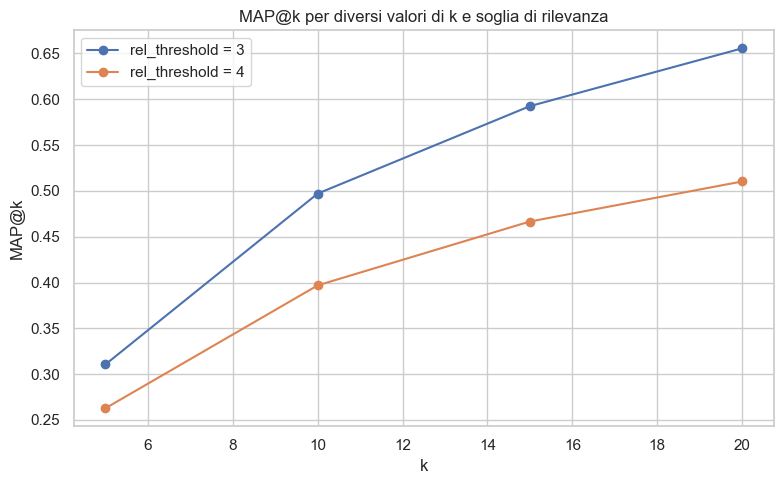

In [92]:
plt.figure(figsize=(8, 5))
for threshold in sorted(mapk['rel_threshold'].unique()):
    subset = mapk[mapk['rel_threshold'] == threshold]
    plt.plot(subset['k'], subset['MAP@k'], marker='o', label=f'rel_threshold = {threshold}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k per diversi valori di k e soglia di rilevanza')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

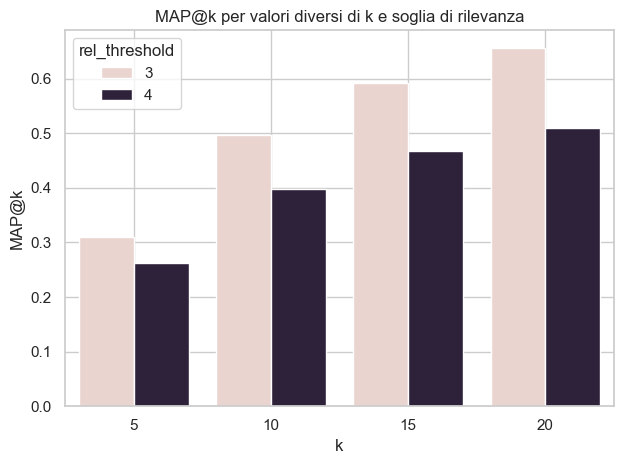

In [ ]:
# Boxplot delle metriche per mapk
sns.barplot(data=mapk, x='k', y='MAP@k', hue='rel_threshold')
plt.title('MAP@k per valori diversi di k e soglia di rilevanza')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.grid(True)
plt.tight_layout()
plt.show()

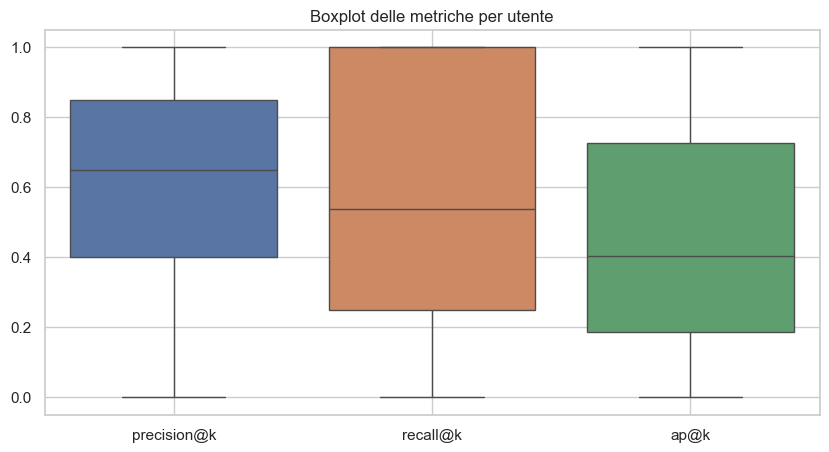

In [ ]:
# Boxplot delle metriche per utente
plt.figure(figsize=(10, 5))
sns.boxplot(data=risultati_utenti[["precision@k", "recall@k", "ap@k"]])
plt.title("Boxplot delle metriche per utente")
plt.grid(True)
plt.show()